In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is connected!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU connected.")

GPU is connected!
GPU Name: Tesla T4


In [ ]:
!pip install langchain -qU
!pip install langchain-openai -qU
!pip install langchain-chroma -qU
!pip install langchain_community -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.2/390.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.1 MB/s eta 0:00:

In [ ]:
import os
from google.colab import userdata

## **Initialize OpenAI LLM**

In [ ]:
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


## **Initialize Embedding Model**

In [ ]:
from langchain_openai import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model = "text-embedding-3-small")

## **Load PDF Document**

In [ ]:
!pip install pypdf -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("/content/Multi Agent Systems-2024 full.pdf")

docs = loader.load()

In [ ]:
len(docs)

169


## **Split Documents into Chunks**

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
splits = text_splitter.split_documents(docs)

In [ ]:
len(splits)

265

In [ ]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model)

In [ ]:
retriever = vectorstore.as_retriever()

## **Define Prompt Template**

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an intelligent chatbot. Use the following context to answer the question. If you don't know the answer, just say that you don't know."
    "\n\n"
    "{context}"
)


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [ ]:
prompt

ChatPromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template="You are an intelligent chatbot. Use the following context to answer the question. If you don't know the answer, just say that you don't know.\n\n{context}"), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={})])

## **Create Retrieval-Augmented Generation (RAG) Chain**

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_chain = create_stuff_documents_chain(llm, prompt)

rag_chain = create_retrieval_chain(retriever, qa_chain)

In [ ]:
response = rag_chain.invoke({"input": "what is features of the MAS?"})
response["answer"]

'The essential features of Multi-Agent Systems (MAS) are communication, coordination, and negotiation. These features are fundamental to the functioning of MAS and enable agents to interact, work together, and reach agreements in order to achieve their goals effectively.'

In [ ]:
response = rag_chain.invoke({"input": "who is the president of us"})
response["answer"]

"I don't have real-time information. As of my last update, I don't know who the current President of the United States is."

In [ ]:
response = rag_chain.invoke({"input": "what is the course module"})
response["answer"]

'The course module for CM 3630 - Multi Agent Systems includes the following topics:\n1. What are Complex Systems?\n2. Agent Technology\n3. Multi Agent Systems\n4. Applications of Multi Agent Systems\n5. Design and development of MAS\n6. Mobile Agent'

## **Add Chat History**

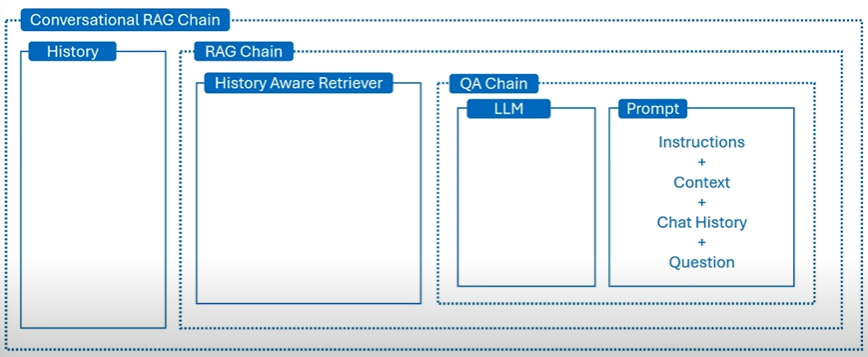

In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_system_prompt = (
    "using chat history and the latest user question, just reformulate question if needed and otherwise return it as is"
)

contextualize_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_prompt
)

## **Create History-Aware RAG Chain**

In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

system_prompt = (
    "You are an intelligent chatbot. Use the following context to answer the question. If you don't know the answer, just say that you don't know."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

prompt

ChatPromptTemplate(input_variables=['chat_history', 'context', 'input'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.

In [ ]:
qa_chain = create_stuff_documents_chain(llm, prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, qa_chain)

In [ ]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

## **Invoke Conversational RAG Chain with Example Questions**

In [ ]:
response = conversational_rag_chain.invoke(
    {"input": "who is Prof. Ashoka"},
    config={"configurable": {"session_id": "101"}},
)
response["answer"]

'Based on the context provided, Prof. Ashoka is likely a reference to Prof. Asoka Karunananda, who is a Senior Professor in the Department of Computation Mathematics and teaches CM 3630 - Multi Agent Systems as part of the BSc Hons in AI program.'

In [ ]:
response = conversational_rag_chain.invoke(
    {"input": "how many mas feactures?"},
    config={"configurable": {"session_id": "101"}},
)
response["answer"]

'There are three essential features of Multi-Agent Systems (MAS):\n1. Communication\n2. Coordination\n3. Negotiation'

In [ ]:
response = conversational_rag_chain.invoke(
    {"input": "can you explain one by one?"},
    config={"configurable": {"session_id": "101"}},
)
response["answer"]

'Certainly! Here is an explanation of each of the essential features of Multi-Agent Systems (MAS):\n\n1. Communication: Communication is a fundamental feature of MAS that allows agents to exchange information, share knowledge, and coordinate their actions. Effective communication enables agents to collaborate, make decisions, and achieve common goals within the system.\n\n2. Coordination: Coordination involves the ability of agents to work together harmoniously towards a shared objective. It includes mechanisms for resolving conflicts, synchronizing activities, and ensuring that individual agent actions align with the overall system goals. Coordination is essential for achieving efficient and effective outcomes in MAS.\n\n3. Negotiation: Negotiation is the process by which agents engage in discussions, make trade-offs, and reach agreements to resolve conflicts or achieve mutually beneficial outcomes. Through negotiation, agents can exchange resources, allocate tasks, and coordinate the